# Import neccessary library

In [16]:
import sys
assert sys.version_info >= (3, 8)

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import visualkeras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os.path import join
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from utils import *

if cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

# Read the train and test images

In [6]:
# read images from training and test folder
train_images = "tsrd-train"
test_images = "TSRD-Test"
train_annotation = "TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt"
test_annotation = "TSRD-Test Annotation/TsignRecgTest1994Annotation.txt"

# Data Visualisation

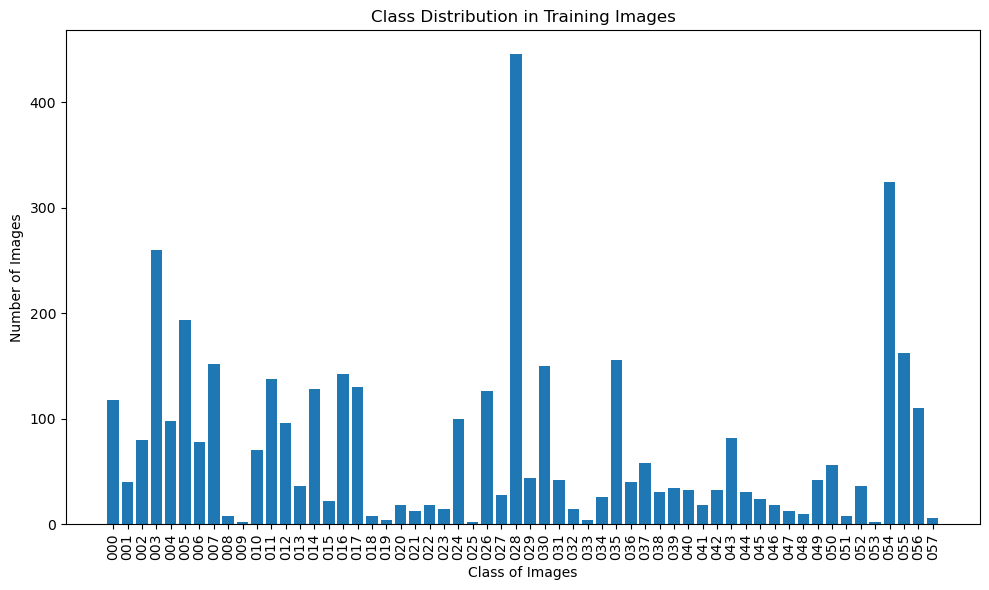

In [6]:
# 
imgs = [img for img in os.listdir(train_images)]

#
imgs_label = [label.split('_')[0] for label in imgs]

#
imgs_class = Counter(imgs_label)
classes = list(imgs_class.keys())
no_imgs = list(imgs_class.values())

# plot class distribution among images
plt.figure(figsize=(10,6))
plt.bar(classes, no_imgs)
plt.xlabel('Class of Images')
plt.ylabel('Number of Images')
plt.title("Class Distribution in Training Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
# Display class counts
print("Class Distribution in Training Set:")
for cls, count in imgs_class.items():
    print(f"Class {cls}: {count} images")

# Check for class imbalance
total_train_images = len(imgs_label)
threshold = 30  # Define imbalance threshold

imbalanced_classes = {cls: count for cls, count in imgs_class.items() if count < threshold}

if imbalanced_classes:
    print("\nClasses with potential imbalance:")
    for cls, count in imbalanced_classes.items():
        print(f"Class {cls}: {count} images (below threshold)")
else:
    print("\nNo class imbalance detected in the training set.")

# Total number of imbalanced classes
total_imbalanced_classes = len(imbalanced_classes)
print(f"\nTotal number of imbalanced classes: {total_imbalanced_classes}")

# List of imbalanced class numbers
imbalanced_class_numbers = list(imbalanced_classes.keys())
print(f"List of imbalanced class numbers: {imbalanced_class_numbers}")

Class Distribution in Training Set:
Class 000: 118 images
Class 001: 40 images
Class 002: 80 images
Class 003: 260 images
Class 004: 98 images
Class 005: 194 images
Class 006: 78 images
Class 007: 152 images
Class 008: 8 images
Class 009: 2 images
Class 010: 70 images
Class 011: 138 images
Class 012: 96 images
Class 013: 36 images
Class 014: 128 images
Class 015: 22 images
Class 016: 142 images
Class 017: 130 images
Class 018: 8 images
Class 019: 4 images
Class 020: 18 images
Class 021: 12 images
Class 022: 18 images
Class 023: 14 images
Class 024: 100 images
Class 025: 2 images
Class 026: 126 images
Class 027: 28 images
Class 028: 446 images
Class 029: 44 images
Class 030: 150 images
Class 031: 42 images
Class 032: 14 images
Class 033: 4 images
Class 034: 26 images
Class 035: 156 images
Class 036: 40 images
Class 037: 58 images
Class 038: 30 images
Class 039: 34 images
Class 040: 32 images
Class 041: 18 images
Class 042: 32 images
Class 043: 82 images
Class 044: 30 images
Class 045: 2

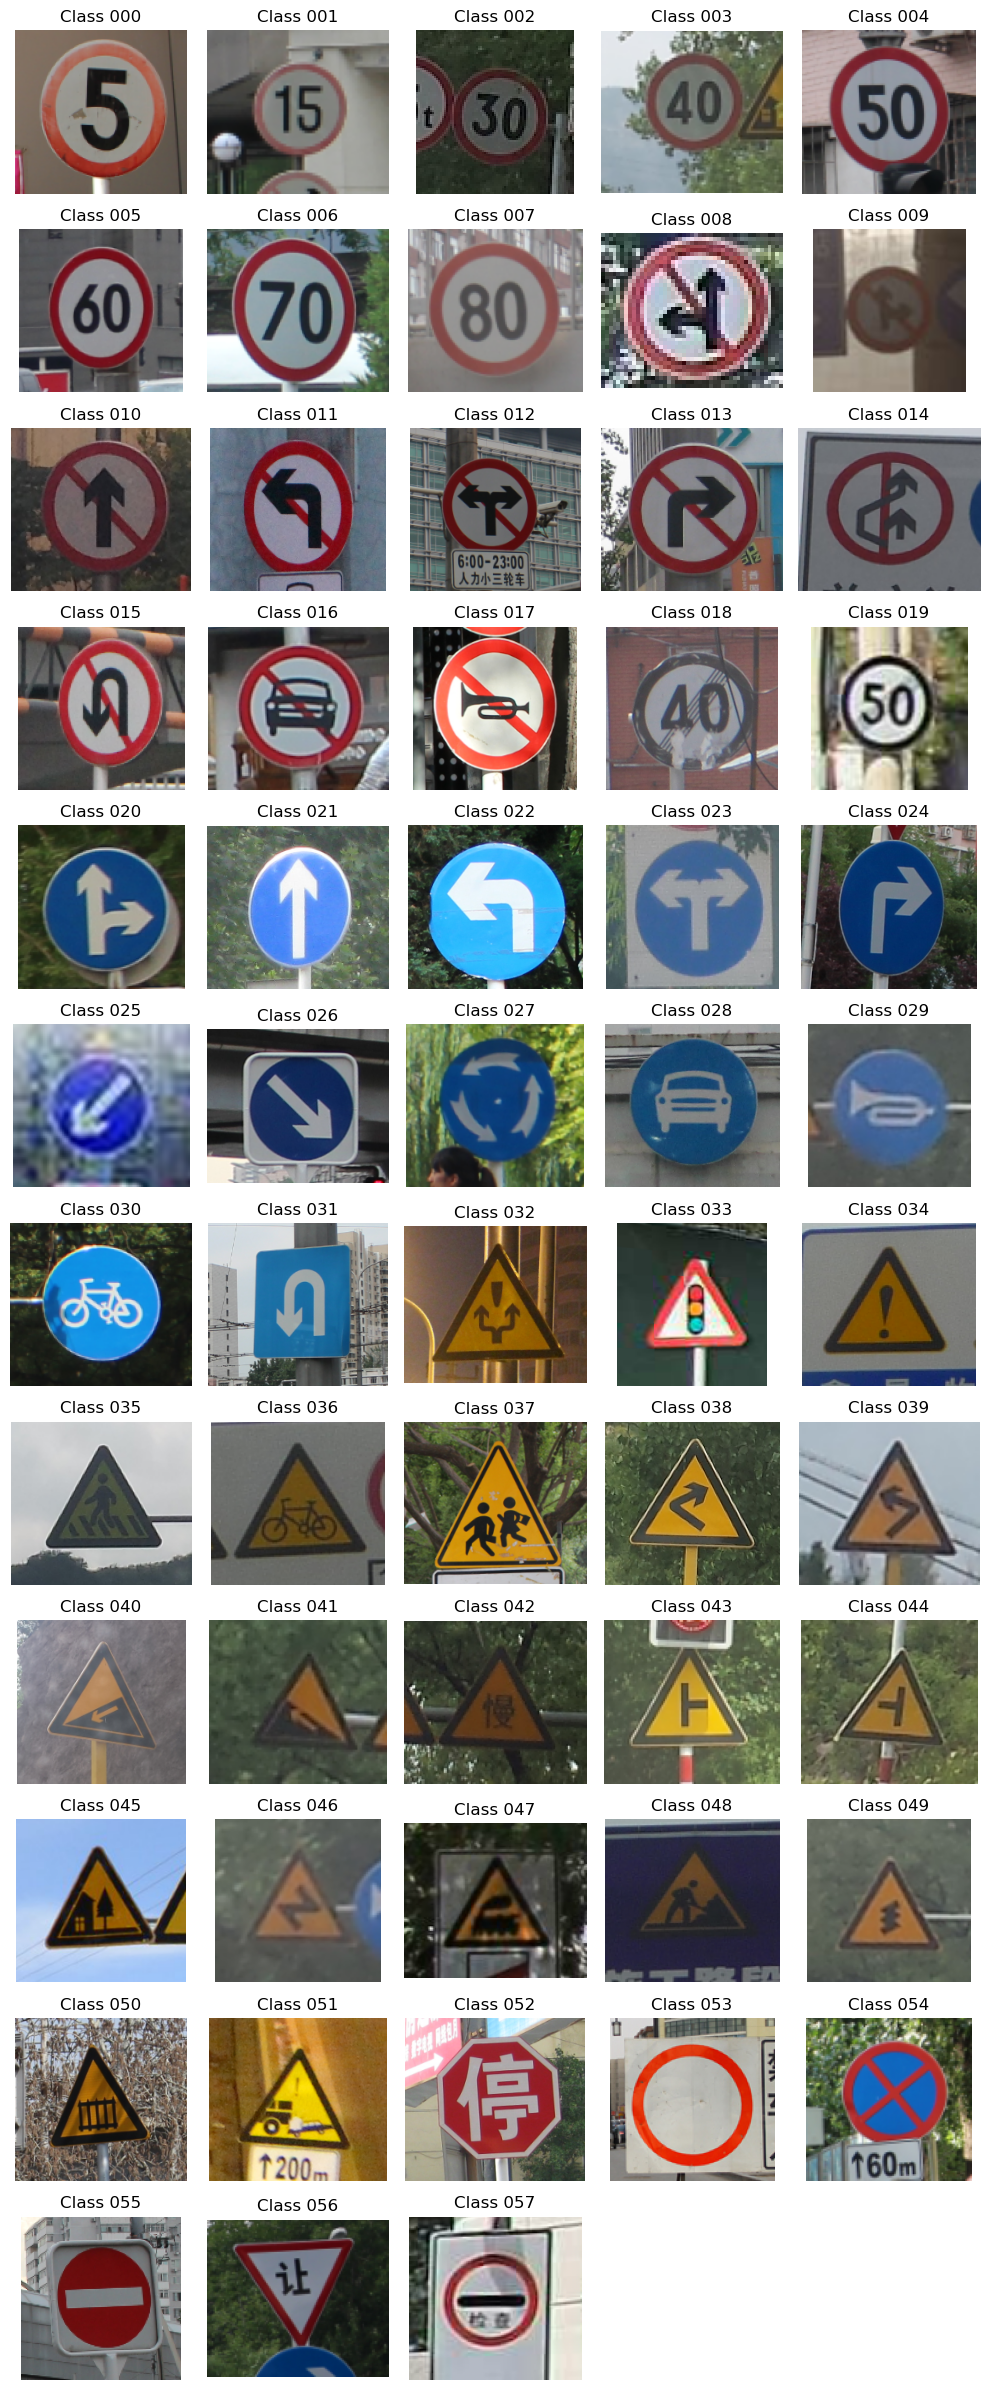

In [14]:
output_img = {}

for img in os.listdir(train_images):
    type = img.split("_")[0]
    if type not in output_img:
        output_img[type] = img

num_classes = len(output_img)
num_columns = 5  # Set number of columns
num_rows = (num_classes + num_columns - 1) // num_columns  # Calculate number of rows needed
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(10, num_rows * 2))

axes = axes.flatten()

for i, (type, img_filename) in enumerate(output_img.items()):
    img_path = os.path.join(train_images, img_filename)
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Class {type}")
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [36]:
train_annotations = pd.read_csv(train_annotation, sep=";", header=None)
train_annotations.drop([8], axis=1, inplace=True)
train_annotations.columns = ["images", "width", "height", "x_start", "y_start", "x_end", "y_end", "class"]
train_annotations.set_index("images", inplace=True)
train_annotations

width  height  x_start  y_start  x_end  y_end  class
images                                                              
000_0001.png      134     128       19        7    120    117      0
000_0002.png      165     151       23       12    149    138      0
000_0003.png      128     122       22       14    116    105      0
000_0010.png       80      73       14        8     67     63      0
000_0011.png      186     174       36       15    155    157      0
...               ...     ...      ...      ...    ...    ...    ...
056_1_0050.png    106     107       15       23     89     87     56
056_1_0051.png    148     147       20       33    123    122     56
056_1_0052.png    218     182       32       26    185    161     56
056_1_0053.png    100     101       12       18     88     85     56
056_1_0054.png    119     110       11       14    103     95     56

[4170 rows x 7 columns]

# Data Preprocessing

In [118]:
def load_images(directory, annotation_file, target_size=(64, 64)):
    images = []
    labels = []
    with open(annotation_file, 'r') as file:
        for line_num, line in enumerate(file.readlines(), start=1):
            print(f"Reading line {line_num} annotations: {line.strip()}")  # Print line which are being read
            parts = line.strip().split(';')
            if len(parts) < 8:  # Ensure there are enough parts to extract filename and bounding box info
                print(f"Warning: Malformed line {line_num} in {annotation_file}: '{line.strip()}'")
                continue
            
            filename = parts[0]  # The first part is the filename
            img_width = int(parts[1])
            img_height = int(parts[2])
            x_start = int(parts[3])
            y_start = int(parts[4])
            x_end = int(parts[5])
            y_end = int(parts[6])
            label_str = parts[7]  # The last part should be the label
            
            if label_str == "":
                print(f"Warning: Empty label on line {line_num} in {annotation_file}")
                continue
        
            try:
                label = int(label_str)  # Attempt to convert the label to an integer
            except ValueError:
                print(f"Error: Invalid label '{label_str}' on line {line_num} in {annotation_file}")
                continue
            
            img_path = os.path.join(directory, filename)
            if not os.path.exists(img_path):
                print(f"Error: File {img_path} does not exist.")
                continue
            
            img = cv.imread(img_path)
            if img is not None:
                # Convert image to RGB format
                img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                
                # Check if the bounding box coordinates are within the image dimensions
                if x_start < 0 or y_start < 0 or x_end > img_width or y_end > img_height:
                    print(f"Warning: Bounding box out of image bounds for {img_path}. Skipping...")
                    continue
                
                # Crop the image using the bounding box coordinates
                cropped_img = img[y_start:y_end, x_start:x_end]

                # Resize the cropped image to the target size
                img_resized = cv.resize(cropped_img, target_size)  
                images.append(img_resized)
                labels.append(label)
                print(f"Loaded, cropped, and resized image: {img_path}, Label: {label}")
            else:
                print(f"Warning: Failed to load image {img_path}.")
    
    print(f"Total images loaded: {len(images)}")
    return np.array(images), np.array(labels)

def normalize_images(images):
    print("Normalizing images....")
    num_images, height, width, channels = images.shape
    images_reshaped = images.reshape(num_images, -1)  # Flatten each image into a single row
    scaler = MinMaxScaler()
    normalized_images = scaler.fit_transform(images_reshaped)
    normalized_images = normalized_images.reshape(images.shape)  # Reshape back to the original format
    print("All images have been normalized.")
    return normalized_images

def denoise_images(images):
    print("Denoising images....")
    denoised_images = []
    for img in images:
        # Ensure the image is in the correct type (uint8)
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)
        
        # Apply denoising
        # Step 1: Apply Median Filtering
        denoised_img = cv.medianBlur(img, ksize=3)

        denoised_images.append(denoised_img)
    print("All images have been denoised successfully.")
    return np.array(denoised_images)

def handle_class_imbalance(X, y):
    print("Handling class imbalancing in images....")
    # Check the number of samples in each class
    unique, counts = np.unique(y, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    
    print(f"Class distribution before SMOTE: {class_distribution}")
    
    # Determine the minimum number of samples in any class
    min_samples = min(counts)
    
    # Adjust n_neighbors for SMOTE if necessary
    n_neighbors = min(min_samples - 1, 5) if min_samples > 1 else 1

    # SMOTE for underrepresented classes
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1), y)

    print(f"Class distribution after SMOTE: {dict(zip(*np.unique(y_resampled, return_counts=True)))}")

    # Random undersampling for overrepresented classes
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_balanced, y_balanced = undersampler.fit_resample(X_resampled, y_resampled)
    
    print(f"Class distribution after undersampling: {dict(zip(*np.unique(y_balanced, return_counts=True)))}")
    
    return X_balanced.reshape(-1, *X.shape[1:]), y_balanced

def preprocess_tsrd(train_dir, test_dir, train_annotation, test_annotation, validation_split_ratio=0.2):
    # Load images with labels
    X_train, y_train = load_images(train_dir, train_annotation)
    X_test, y_test = load_images(test_dir, test_annotation)

    # Stratified split of the training data into training and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=validation_split_ratio, random_state=42, stratify=y_train
    )
    print(f"Split training data into {len(X_train)} training samples and {len(X_val)} validation samples.")

    # Denoise images
    X_train = denoise_images(X_train)
    X_val = denoise_images(X_val)
    X_test = denoise_images(X_test)

    # Normalize images
    X_train = normalize_images(X_train)
    X_val = normalize_images(X_val)
    X_test = normalize_images(X_test)

    # Handle class imbalance (only for the training set)
    X_train, y_train = handle_class_imbalance(X_train, y_train)

    return X_train, y_train, X_val, y_val, X_test, y_test

# Preprocess the data
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_tsrd(train_images, test_images, train_annotation, test_annotation)

# Output the shape of the processed data
print(f"Processed training set shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Processed validation set shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Processed test set shape: {X_test.shape}, labels shape: {y_test.shape}")

Reading line 1 annotations: 000_0001.png;134;128;19;7;120;117;0;
Loaded, cropped, and resized image: tsrd-train\000_0001.png, Label: 0
Reading line 2 annotations: 000_0002.png;165;151;23;12;149;138;0;
Loaded, cropped, and resized image: tsrd-train\000_0002.png, Label: 0
Reading line 3 annotations: 000_0003.png;128;122;22;14;116;105;0;
Loaded, cropped, and resized image: tsrd-train\000_0003.png, Label: 0
Reading line 4 annotations: 000_0010.png;80;73;14;8;67;63;0;
Loaded, cropped, and resized image: tsrd-train\000_0010.png, Label: 0
Reading line 5 annotations: 000_0011.png;186;174;36;15;155;157;0;
Loaded, cropped, and resized image: tsrd-train\000_0011.png, Label: 0
Reading line 6 annotations: 000_0012.png;186;164;22;15;162;150;0;
Loaded, cropped, and resized image: tsrd-train\000_0012.png, Label: 0
Reading line 7 annotations: 000_0013.png;158;127;31;15;134;113;0;
Loaded, cropped, and resized image: tsrd-train\000_0013.png, Label: 0
Reading line 8 annotations: 000_0014.png;155;125;27;13

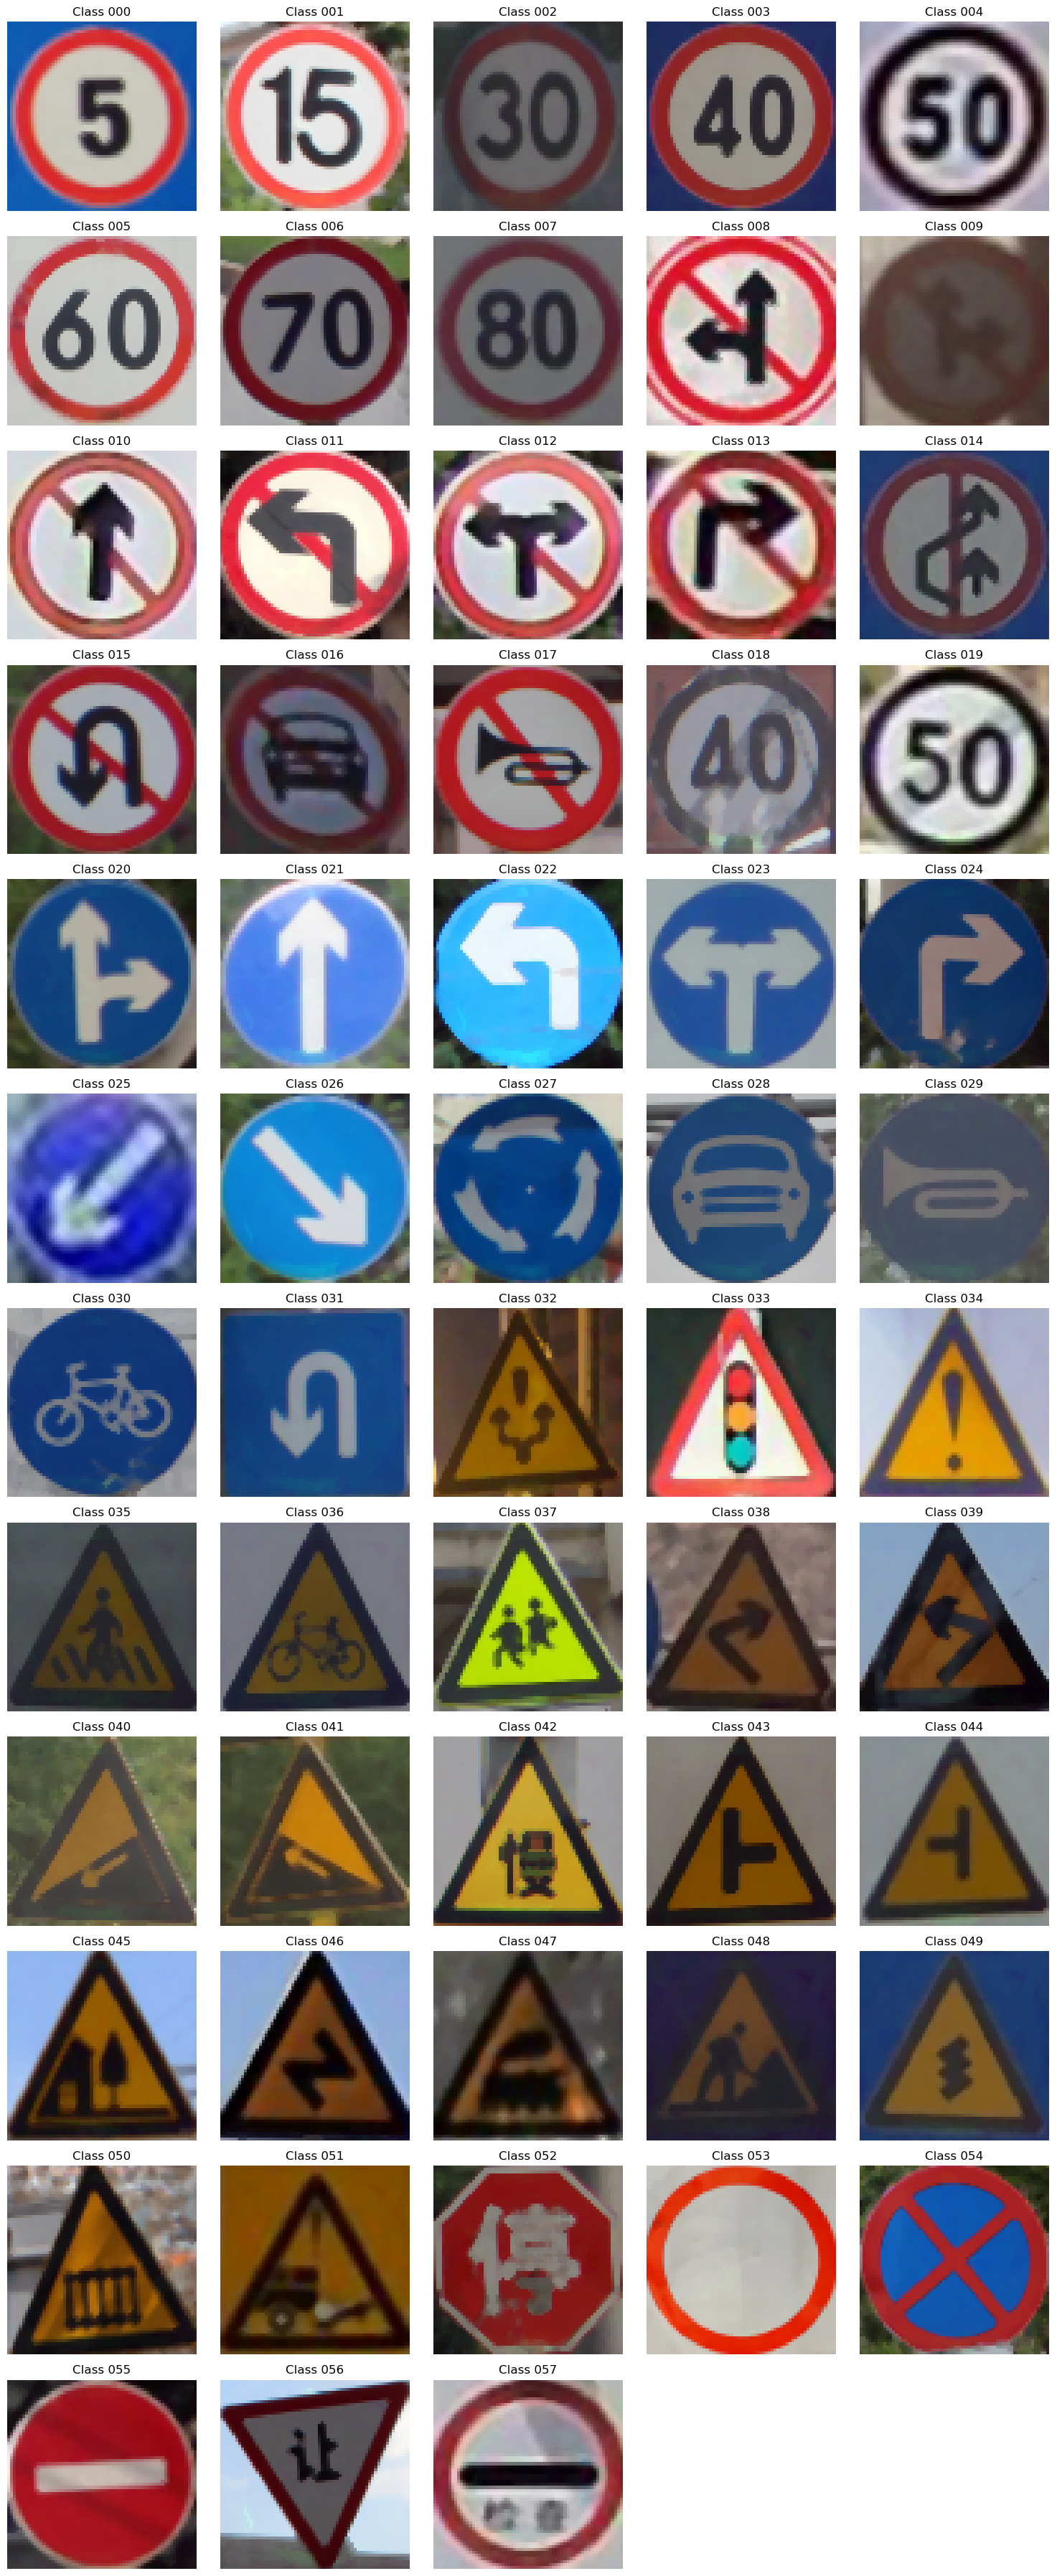

In [120]:
def display_images_by_class(X, y, class_labels):
    """
    Display one image per class after preprocessing, converting to RGB format.
    
    Args:
    - X: Preprocessed images array (e.g., shape (n_samples, height, width, channels))
    - y: Labels corresponding to each image in X
    - class_labels: List or array of class labels to display
    
    Returns:
    - None
    """
    unique_classes = np.unique(y)
    num_classes = len(unique_classes)
    num_columns = 5
    num_rows = (num_classes + num_columns - 1) // num_columns  # Calculate number of rows needed

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, num_rows * 3))
    axes = axes.flatten()

    for i, cls in enumerate(unique_classes):
        # Find the first index of an image with the class label 'cls'
        idx = np.where(y == cls)[0][0]
        img = X[idx]
        
        # Convert the image to uint8 if it's not already
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        # Convert image from BGR to RGB format
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        axes[i].set_title(f"Class {cls:03}")
        axes[i].axis('off')

    # Turn off any remaining axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage with your preprocessed datasets
display_images_by_class(X_train, y_train, np.unique(y_train))

In [49]:
category = {"000" : "Speed limit 5km/h",
            "001" : "Speed limit 15km/h",
            "002" : "Speed limit 30km/h",
            "003" : "Speed limit 40km/h",
            "004" : "Speed limit 50km/h",
            "005" : "Speed limit 60km/h",
            "006" : "Speed limit 70km/h",
            "007" : "Speed limit 80km/h",
            "008" : "No turn left or go straight",
            "009" : "No turn right or go straight",
            "010" : "No go straight",
            "011" : "No turn left",
            "012" : "No turn left or right",
            "013" : "No turn right",
            "014" : "No overtaking",
            "015" : "No u-turn",
            "016" : "No entry for vehicles",
            "017" : "No horn",
            "018" : "Speed limit 40KM/H ended",
            "019" : "Speed limit 50KM/H ended",
            "020" : "Turn right or go straight",
            "021" : "Go straight",
            "022" : "Turn left",
            "023" : "Turn left or turn right",
            "024" : "Turn Right",
            "025" : "Stay at the left lane",
            "026" : "Stay at the right lane",
            "027" : "Roundabout",
            "028" : "Car lane",
            "029" : "Horn allowed",
            "030" : "Bicycle lane",
            "031" : "U-turn allowed",
            "032" : "Bypass left and right",
            "033" : "Traffic light ahead",
            "034" : "Beware of danger",
            "035" : "Beware of pedestrian",
            "036" : "Beware of bicycles",
            "037" : "Beware of students",
            "038" : "Sharp right turn",
            "039" : "Sharp left turn",
            "040" : "Downhill road",
            "041" : "Uphill road",
            "042" : "Slow down",
            "043" : "Right lane T-junction",
            "044" : "Left lane T-junction",
            "045" : "Village or Residential Area Ahead",
            "046" : "Winding Road",
            "047" : "Unguarded railway crossings",
            "048" : "Construction ahead",
            "049" : "Continuous turn road",
            "050" : "Guarded railway crossing ahead",
            "051" : "Accident prone ahead",
            "052" : "Stop sign",
            "053" : "No vehicle",
            "054" : "Parking prohibited",
            "055" : "No entry",
            "056" : "Give way",
            "057" : "Stop for roadblock",
           }

In [19]:
input_shape = (64, 64, 3) 
num_classes = 58

# Data generators for augmentation
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

NameError: name 'X_train' is not defined

In [25]:
def create_vgg16(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    model = keras.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

vgg16_model = create_vgg16(input_shape, num_classes)
vgg16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 58)                  │          14,906 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,254,138 (58.19 MB)

 Trainable params: 15,254,138 (58.19 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
visualkeras.layered_view(vgg16_model)

In [29]:
def create_resnet18(input_shape, num_classes):
    # Using ResNet50 as a proxy for ResNet18
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

resnet18_model = create_resnet18(input_shape, num_classes)
resnet18_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 138s 1us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 70, 70, 3)         │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 32, 32, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 32, 32, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 32, 32, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 34, 34, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 16, 16, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 16, 16, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 16, 16, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 16, 16, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 16, 16, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,857,466 (91.01 MB)

 Trainable params: 23,804,346 (90.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

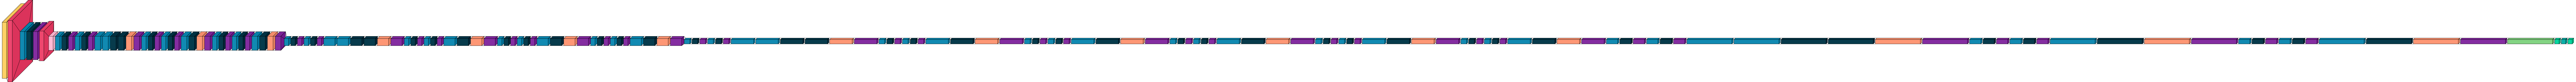

In [31]:
visualkeras.layered_view(resnet18_model)

In [45]:
def create_mobilenetv2(num_classes, input_shape=(96, 96, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenetv2_model = create_mobilenetv2(num_classes)
mobilenetv2_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 12s 1us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 96, 96, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 48, 48, 32)        │             864 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 48, 48, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 48, 48, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 48, 48, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 48, 48, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 48, 48, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 48, 48, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 48, 48, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 48, 48, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 48, 48, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 48, 48, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 49, 49, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 24, 24, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,429,434 (9.27 MB)

 Trainable params: 2,395,322 (9.14 MB)

 Non-trainable params: 34,112 (133.25 KB)

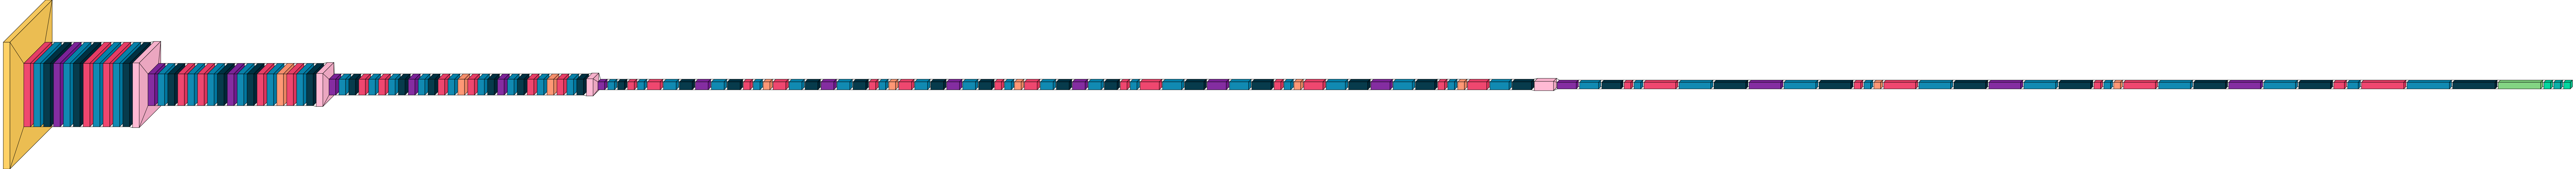

In [47]:
visualkeras.layered_view(mobilenetv2_model)

In [ ]:
# Train VGG-16
print("Training VGG-16...")
vgg16_model.fit(train_generator, validation_data=val_generator, epochs=10)

# Train ResNet-18
print("Training ResNet-18...")
resnet18_model.fit(train_generator, validation_data=val_generator, epochs=10)

# Train MobileNetV2
print("Training MobileNetV2...")
mobilenetv2_model.fit(train_generator, validation_data=val_generator, epochs=10)

In [ ]:
# Evaluate VGG-16
vgg16_score = vgg16_model.evaluate(X_test, y_test, verbose=0)
print(f"VGG-16 Test Accuracy: {vgg16_score[1]:.4f}")

# Evaluate ResNet-18
resnet18_score = resnet18_model.evaluate(X_test, y_test, verbose=0)
print(f"ResNet-18 Test Accuracy: {resnet18_score[1]:.4f}")

# Evaluate MobileNetV2
mobilenetv2_score = mobilenetv2_model.evaluate(X_test, y_test, verbose=0)
print(f"MobileNetV2 Test Accuracy: {mobilenetv2_score[1]:.4f}")